In [38]:
import torch
from config import MODELS_PATH, CACHE_PATH
from data import TEST_DATA
import json


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

run = "run_71"
# run = "run_103"
image = 11947

model_path = (MODELS_PATH / run).with_suffix(".pth")
params_path = (MODELS_PATH / run).with_suffix(".json")
with open(params_path) as f:
    hyperparameters = json.load(f)
hyperparameters

{'batch_size': 64,
 'edit_count': 8,
 'bin_count': 16,
 'clip_gradients': True,
 'learning_rate': 0.0006259590312601935,
 'scheduler_gamma': 0.6114598296902418,
 'num_epochs': 5,
 'model_type': 'Residual',
 'loss': 'kl'}

In [28]:
from editor.training import HistogramDataset
from editor.visualisation import plot_histograms_in_2d
from editor.models import create_model

dataset = HistogramDataset(
    TEST_DATA,
    edit_count=hyperparameters["edit_count"],
    bin_count=hyperparameters["bin_count"],
    delete_corrupt_images=False,
    cache_path=CACHE_PATH,
    target_size=(640, 640),
)

model = create_model(
    type=hyperparameters["model_type"],
    bin_count=hyperparameters["bin_count"],
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Residual(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
  (decon

In [29]:
from editor.visualisation import plot_histograms_in_3d
from editor.utils import compute_histogram


original_image = dataset.get_original_image(image)
original_histogram = (
    torch.tensor(
        compute_histogram(
            original_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        dtype=torch.float,
    )
    .unsqueeze(0)
    .unsqueeze(0)
)

edited_image = dataset.get_edited_image(image, 3)
edited_histogram = (
    torch.tensor(
        compute_histogram(
            edited_image, bins=hyperparameters["bin_count"], normalize=True
        )
    )
    .unsqueeze(0)
    .unsqueeze(0)
)

original_histogram = original_histogram.to(device)
edited_histogram = edited_histogram.to(device)

predicted_histogram = model(edited_histogram)
predicted_histogram = predicted_histogram / torch.sum(
    predicted_histogram, dim=(2, 3, 4), keepdim=True
)
plot_histograms_in_3d(
    {
        "original": original_histogram.cpu().numpy().squeeze(),
        "edited": edited_histogram.cpu().numpy().squeeze(),
        "predicted": predicted_histogram.cpu().detach().numpy().squeeze(),
    }
)

In [30]:
import numpy as np

[h, w, _] = np.array(edited_image).shape

histogram = np.round(
    predicted_histogram.cpu().detach().numpy().squeeze() * h * w
).astype(int)

rgb_vectors = []

for r in range(histogram.shape[0]):
    for g in range(histogram.shape[1]):
        for b in range(histogram.shape[2]):
            # Append the RGB value 'count' times to the list
            for _ in range(histogram[r, g, b]):
                rgb_vectors.append([r, g, b])

rgb_vectors = np.array(rgb_vectors)
rgb_vectors = rgb_vectors * (256 / hyperparameters["bin_count"])

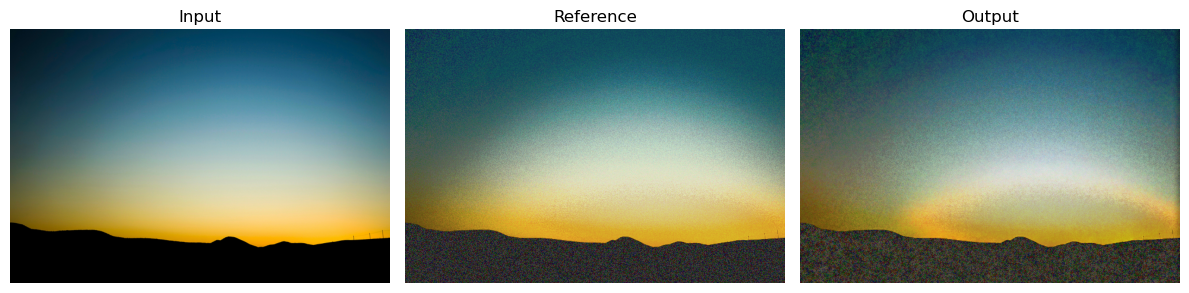

In [31]:
from editor.visualisation import display_images
from editor.histogram_transfer import pdf_transfer_3d
from PIL import Image


output = pdf_transfer_3d(
    source=np.array(edited_image),
    target_flattened=rgb_vectors.transpose(),
    relaxation=0.5,
    bin_count=5000,
    iterations=20,
    smoothness=1,
    should_regrain=True,
)

display_images(
    {
        "Input": original_image,
        "Reference": edited_image,
        "Output": Image.fromarray(output),
    }
)
plot_histograms_in_3d(
    {
        "original": compute_histogram(
            original_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        "edited": compute_histogram(
            edited_image, bins=hyperparameters["bin_count"], normalize=True
        ),
        "predicted": compute_histogram(
            Image.fromarray(output), bins=hyperparameters["bin_count"], normalize=True
        ),
    },
)